# Machine Learning: From Theory to Practise -- Project
## Master Data Science -- Université Paris Saclay
## Natural Naguage Processing Applied to Sentiment Analysis
#### Authors: Johann Faouzi, Hicham Janati, Mélanie Finas, Peter Martigny

#### Amazon Book Reviews - https://archive.ics.uci.edu/ml/datasets/Amazon+book+reviews

### The goal of this project is to predict how much a reader would rate a book based on her/his textual review
### We will follow this methodology:

#### Short exploration

#### Cleaning of reviews

#### Bag of words model to create features

#### Classification & Regression algorithms to predict the ratings

#### Using [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) to embed words into contextual vectors, then use average vectors or clustering to create features for ML algorithms

In [1]:
## Some useful package imports
import pandas as pd
from bs4 import BeautifulSoup
import time
import numpy as np

import nltk
from nltk.stem.porter import *
import string
from nltk.tokenize import TweetTokenizer
token = TweetTokenizer()
stemmer = PorterStemmer() 
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
%matplotlib inline

## Load the datasets

In [2]:
# Load the first book
data = pd.read_csv('Paula_Hawkins-The-Girl-On-The-Train.csv', sep = '\t', header = None)
# Rename columns
data.columns = ['rating', 'tail', 'title', 'review']
data['book'] = 'Paula_Hawkins-The-Girl-On-The-Train'

# Load the second book
data1 = pd.read_csv('Andy-Weir-The-Martian.csv', sep = '\t', header = None)
# Rename columns
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Andy-Weir-The-Martian'

# Concatenate into one dataframe
data = pd.concat((data, data1))
# Reset index and remove the index column
data = data.reset_index().ix[:, 1:]


############## Concatenate the other books ########################

data1 = pd.read_csv('Donna-Tartt-The-Goldfinch.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Donna-Tartt-The-Goldfinch'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('EL-James-Fifty-Shades-of-Grey.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'EL-James-Fifty-Shades-of-Grey'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('Fillian_Flynn-Gone_Girl.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Fillian_Flynn-Gone_Girl'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('John-Green-The-Fault-in-our-Stars.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'John-Green-The-Fault-in-our-Stars'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('Laura-Hillenbrand-Unbroken.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Laura-Hillenbrand-Unbroken'

########## Final concatenation ##############
data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

print('The dataframe contains ', data.shape[0], ' rows, which consist of reviews from ', len(data.book.unique()), 
      ' different books\n')

for book in data.book.unique():
    print(book, ' has ', len(data[data.book == book]), ' reviews')

The dataframe contains  219242  rows, which consist of reviews from  7  different books

Paula_Hawkins-The-Girl-On-The-Train  has  37139  reviews
Andy-Weir-The-Martian  has  22571  reviews
Donna-Tartt-The-Goldfinch  has  22861  reviews
EL-James-Fifty-Shades-of-Grey  has  32977  reviews
Fillian_Flynn-Gone_Girl  has  41974  reviews
John-Green-The-Fault-in-our-Stars  has  35844  reviews
Laura-Hillenbrand-Unbroken  has  25876  reviews


In [3]:
print("In total, we have {} reviews.".format(data.shape[0]))

In total, we have 219242 reviews.


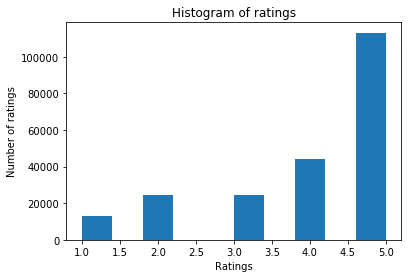

In [4]:
plt.hist(data.rating)
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.title('Histogram of ratings')
plt.show()

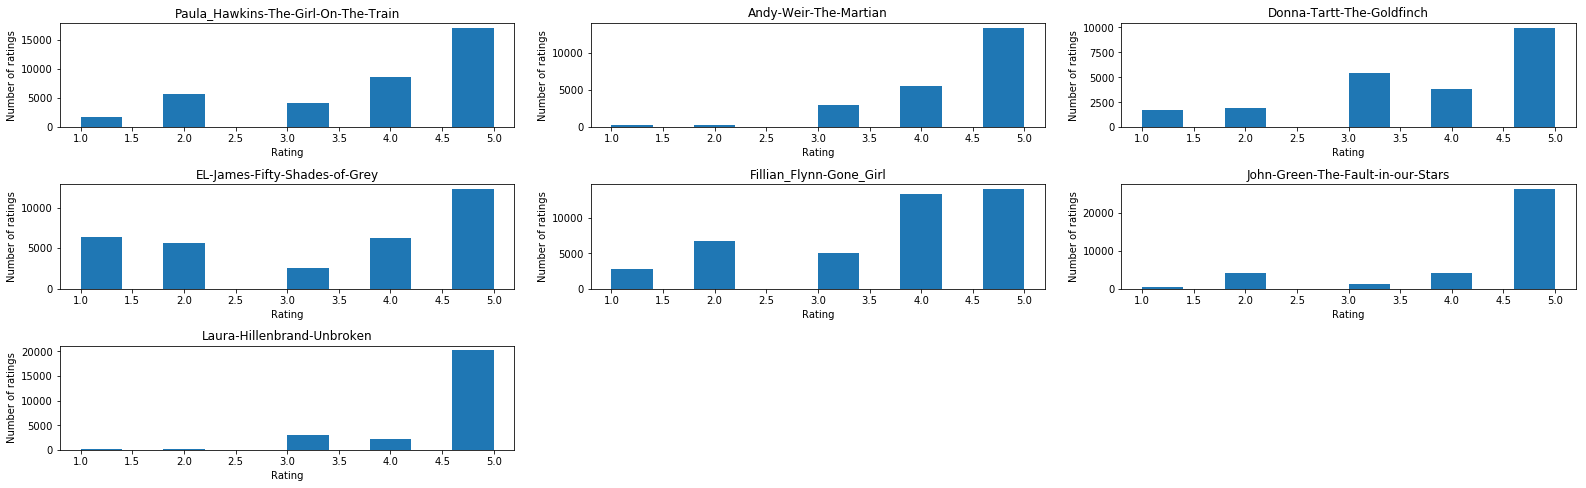

In [5]:
#Plot for the new dataset (preprocessed)
plt.figure(figsize=(22.0, 22.0))
cmptr=1
for book in data.book.unique():
    plt.subplot(10,3,cmptr)
    plt.hist(data[data.book == book]['rating'])
    plt.tight_layout(pad=0.6, w_pad=2, h_pad=1.0)
    plt.xlabel('Rating')
    plt.ylabel('Number of ratings')
    plt.title(book)
    cmptr+=1
plt.show()

We notice that some books have mostly good ratings (e.g. "Unbroken"), whereas some others have more uniform rating distributions (e.g. "Gone Girl").

# Toy Dataset

#### We will use only a part of the reviews from the book "The Girl on the Train", Paula Hawkins

In [6]:
# We select only one book
single_book = data[data.book == 'Paula_Hawkins-The-Girl-On-The-Train']

In [7]:
# Here we will define negative, neutral and positive reviews
def sentiment(x):
    if x < 3:
        return -1
    if x == 3:
        return 0
    else:
        return 1
single_book['sentiment'] = single_book['rating'].apply(lambda x: sentiment(x))

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


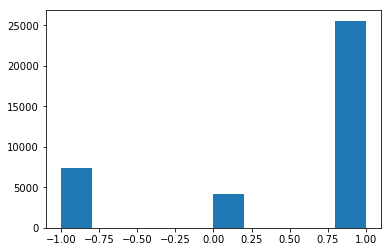

In [8]:
plt.hist(single_book.sentiment)
plt.show()

Before doing anything, we observe that the target variable is clearly imbalanced.
One solution to imbalanced data, when we want to separare the data into train and test sets, is that we want to keep the same distribution of the data in both sets. This is feasable with stratified sampling using sklearn.
However, here, since the target variable is too much imbalanced, there's a high risk that any predictor will always predict the dominant class! Indeed, whatever happens, this will produce a very decent accuracy, but it is likely to be not effective for being discriminant.
One solution is to keep all instances of non dominant class, and sampling over the dominant classes such that all classes are equivalantly represented. We will then have more confidance in our classification algorithm. The downside is that we loose some data...

In [9]:
print(single_book.sentiment.value_counts())
print('Minimum representation for classes:', single_book.sentiment.value_counts().min())

 1    25577
-1     7399
 0     4163
Name: sentiment, dtype: int64
Minimum representation for classes: 4163


4163


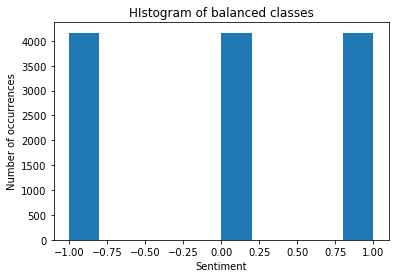

In [10]:
# Index of positive, negative and neutral data
index_positive = list(single_book[single_book.sentiment == 1].index)
index_negative = list(single_book[single_book.sentiment == -1].index)
index_neutral = list(single_book[single_book.sentiment == 0].index)

# Sample over the negative and positive data
min_class = single_book.sentiment.value_counts().min()
print(min_class)
index_positive_sample = list(single_book.ix[index_positive].sample(min_class).index)
index_negative_sample = list(single_book.ix[index_negative].sample(min_class).index)
index_final = index_negative_sample + index_positive_sample + index_neutral

# We define our toy dataset with balanced classes
toy_data = single_book.ix[index_final]
# Reset the index
toy_data = toy_data.reset_index().ix[:, 1:]

# Plot the histogram of classes
plt.hist(toy_data.sentiment)
plt.title('HIstogram of balanced classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of occurrences')
plt.show()

In [11]:
# Size of the resulting toy dataset
print('Our toy dataset has now {} rows'.format(toy_data.shape[0]))

Our toy dataset has now 12489 rows


## Let's have a look at the reviews

In [12]:
toy_data.review[10]

'<span class="a-size-base review-text">Great mystery!</span>'

It looks that the reviews are in HTML format! We will remove first remove html tages. As additional pre processing, we will also remove non-letters characters, use lowercases everywhere and remove stopwords (the words that occur too often like "the", "a", ... as they might not contain a lot of information and removing them reduces a lot the dimension of the problem.

In [13]:
def process(x):
    '''
    Function to clear the html tags, then remove non-letters characters, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''

    # Clean html tags
    review = BeautifulSoup(x, "html.parser").get_text() 
    
    # Remove non letters     
    letters = re.sub("[^a-zA-Z]", " ", review) 
    
    # Lowercase and split to words
    words = letters.lower().split()                              
    
    # Join to produce the cleaned texts 

    return(" ".join(words))  

We create the column with clean reviews (according to your machine, this can take a little time):

In [14]:
toy_data['processed'] = toy_data['review'].apply(lambda x: process(x))

In [15]:
# An example
toy_data.processed[10]

'great mystery'

# Strategy 1:  Bag of Words Model

In the model of Bag of words, we simplify the text by summarizing it as a list of distinct words, each being described by its relative frequency. Hence, we get rid of word order dependency, and observe only if a word occurs often for positive ratings or for negative ratings, and we would like to investigate if this is sufficient to predict well the ratings.

We first use the Count Vectorizer from scikit learn. Moreover, we will restraint to the $5000$ most frequent words (computation time).

In [16]:
print("Wait, bags of words are being created!!\n")
from sklearn.feature_extraction.text import CountVectorizer
# Define the function that will compute the frequencies for all words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 
# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(toy_data['processed'])
# Convert the result to an array
train_data_features = train_data_features.toarray()

print('The model has been learned!')

Wait, bags of words are being created!!

The model has been learned!


As the words usually appear in only a few reviews, the matrix produced is likely to be very sparse!

In [17]:
# Examine the size and the sparsity of the tfidf_matrix
size = train_data_features.shape
sparsity = np.count_nonzero(train_data_features) / train_data_features.size

print('The matrix is of shape '+str(size)+' and its sparsity is '+str(sparsity))

The matrix is of shape (12489, 5000) and its sparsity is 0.004717111057730803


We observe that the matrix is constituted of around $99.6 \%$ zeros!

In [18]:
print('There are ', train_data_features.shape[0], ' rows and ', train_data_features.shape[1], ' features')

There are  12489  rows and  5000  features


In [19]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['aa', 'abandoned', 'abdic', 'ability', 'able', 'abound', 'about', 'above', 'abrupt', 'absent', 'absolute', 'absolutely', 'absorbed', 'absorbing', 'absurd', 'abuse', 'abused', 'abusive', 'abyss', 'accept', 'acceptable', 'accident', 'acclaim', 'acclaimed', 'accomplished', 'according', 'account', 'accounts', 'accurate', 'accurately', 'achieve', 'achieved', 'acquainted', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'actively', 'activities', 'actors', 'actresses', 'acts', 'actual', 'actually', 'adaptation', 'add', 'added', 'addict', 'addicted', 'addicting', 'addiction', 'addictions', 'addictive', 'addicts', 'adding', 'addition', 'additional', 'adds', 'adequately', 'adjust', 'adjusted', 'admirable', 'admiration', 'admire', 'admit', 'admittedly', 'adore', 'adult', 'adulterer', 'adulterers', 'adultery', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'advertised', 'advice', 'affair', 'affairs', 'affects', 'affinity', 'afford', 'afraid', 'after', 'afternoon', '

In [20]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

5 aa
3 abandoned
5 abdic
18 ability
166 able
3 abound
1265 about
21 above
3 abrupt
4 absent
7 absolute
93 absolutely
22 absorbed
27 absorbing
9 absurd
37 abuse
12 abused
23 abusive
3 abyss
10 accept
5 acceptable
6 accident
3 acclaim
4 acclaimed
8 accomplished
3 according
9 account
14 accounts
13 accurate
5 accurately
4 achieve
4 achieved
5 acquainted
31 across
12 act
7 acted
3 acting
60 action
54 actions
7 active
4 actively
3 activities
8 actors
3 actresses
8 acts
27 actual
166 actually
4 adaptation
52 add
24 added
3 addict
8 addicted
17 addicting
39 addiction
5 addictions
14 addictive
3 addicts
19 adding
13 addition
3 additional
19 adds
4 adequately
4 adjust
3 adjusted
8 admirable
4 admiration
10 admire
44 admit
6 admittedly
5 adore
8 adult
5 adulterer
3 adulterers
7 adultery
5 adults
8 advance
3 advanced
3 advantage
6 adventure
6 advertised
6 advice
24 affair
9 affairs
4 affects
3 affinity
4 afford
7 afraid
421 after
20 afternoon
3 afterwards
197 again
15 against
9 agatha
13 age
10 a

Let's have a look at the most used words in our corpus:

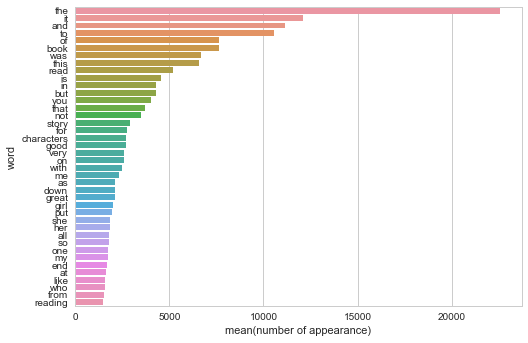

In [21]:
import seaborn as sns
ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)

We remark that the most used words are stopwords, hence we will remove them!

In [22]:
def remove_stop_words(review):
    review = review.split()
    stops = set(stopwords.words("english"))                  
    text = [w for w in review if not w in stops]   
    return(" ".join(text))  
toy_data['processed'] = toy_data['processed'].apply(lambda x: remove_stop_words(x))

Wait, bags of words are being created!!

The model has been learned!


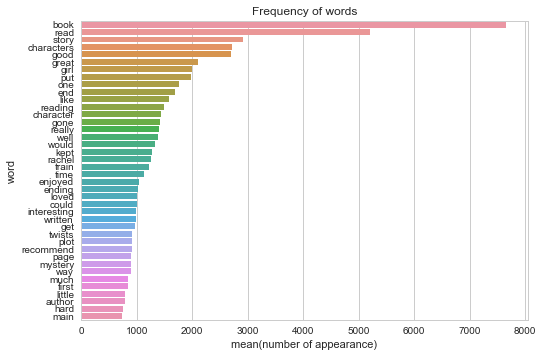

In [23]:
print("Wait, bags of words are being created!!\n")
from sklearn.feature_extraction.text import CountVectorizer
# Define the function that will compute the frequencies for all words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 
# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(toy_data['processed'])
# Convert the result to an array
train_data_features = train_data_features.toarray()

print('The model has been learned!')
size = train_data_features.shape
sparsity = np.count_nonzero(train_data_features) / train_data_features.size
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)

ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)
plt.title('Frequency of words')
plt.show()

We observe that some of the most represented words are related to emotions ("great", "like", "enjoyed", "loved", ... which is important for our application).

We also observe that the number of appearance is rapidly deacreasing.

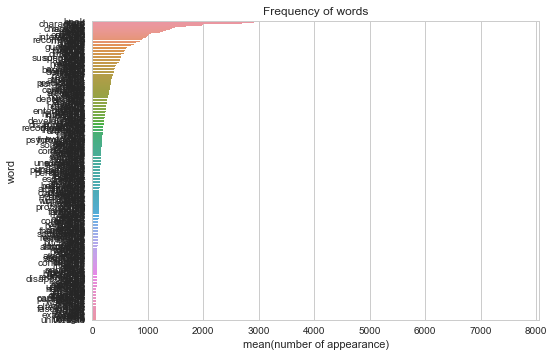

In [24]:
ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(500)
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)
plt.title('Frequency of words')
plt.show()

# Classification

We will now build models to predict the rating based on the reviews' features.

In [25]:
import time
from sklearn.model_selection import train_test_split
labels = toy_data['sentiment']

# We split the data into train and test data. Here we keep 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

In [26]:
data_train.shape

(8742, 5000)

#### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  1.110008955001831


The accuracy is:  0.346944222044


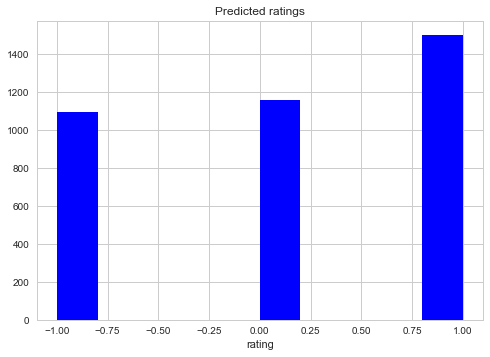

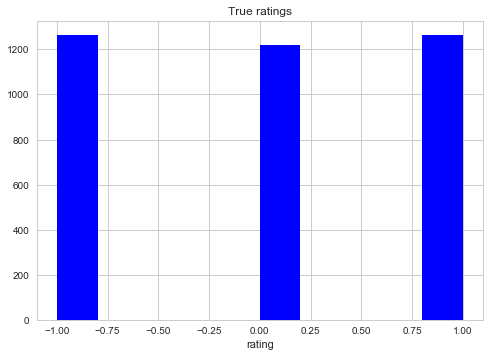

In [28]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))
plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

Confusion matrix, without normalization
[[368 399 497]
 [357 397 466]
 [368 360 535]]


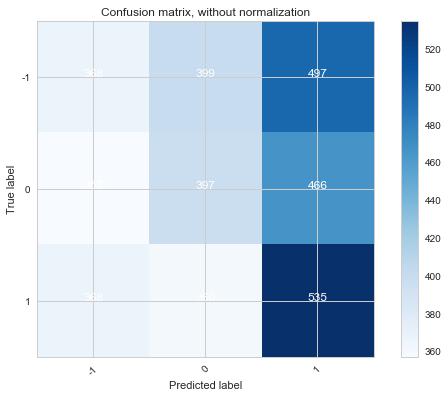

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [30]:
from sklearn.metrics import classification_report
target_names = ['class -1', 'class 0', 'class 1']
print(classification_report(labels_test, labels_predicted, target_names=target_names))

             precision    recall  f1-score   support

   class -1       0.34      0.29      0.31      1264
    class 0       0.34      0.33      0.33      1220
    class 1       0.36      0.42      0.39      1263

avg / total       0.35      0.35      0.34      3747



Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  0.6021981239318848
The accuracy is:  0.363757672805
Confusion matrix, without normalization
[[343 390 531]
 [314 401 505]
 [275 369 619]]


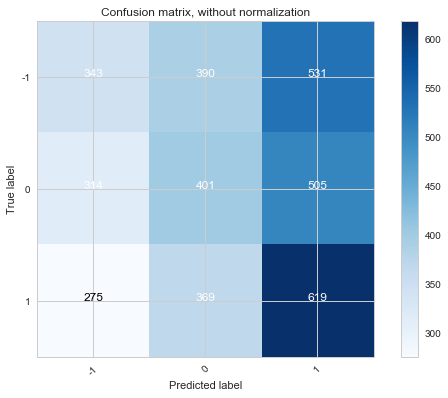

             precision    recall  f1-score   support

   class -1       0.37      0.27      0.31      1264
    class 0       0.35      0.33      0.34      1220
    class 1       0.37      0.49      0.42      1263

avg / total       0.36      0.36      0.36      3747

The accuracy is:  0.363757672805


In [31]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C=.01)
# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)
print("Computation time: ", time.time() - start)

print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  11.336165189743042
Confusion matrix, without normalization
[[430 441 393]
 [384 453 383]
 [367 430 466]]


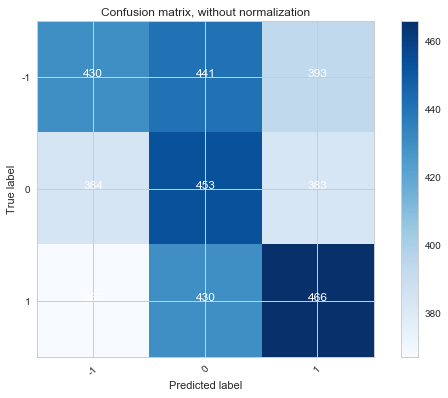

             precision    recall  f1-score   support

   class -1       0.36      0.34      0.35      1264
    class 0       0.34      0.37      0.36      1220
    class 1       0.38      0.37      0.37      1263

avg / total       0.36      0.36      0.36      3747

The accuracy is:  0.360021350414


In [32]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 20, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  13.392089605331421
Confusion matrix, without normalization
[[2181  700 4405]
 [ 970 1093 5220]
 [ 749  852 5774]]


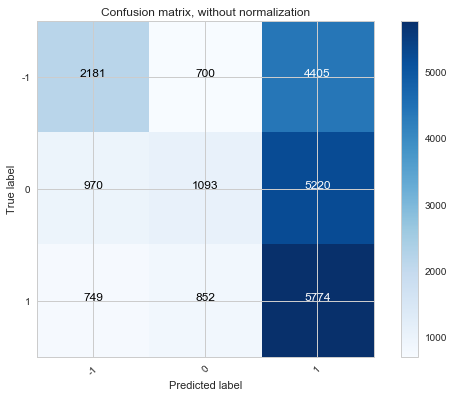

             precision    recall  f1-score   support

   class -1       0.56      0.30      0.39      7286
    class 0       0.41      0.15      0.22      7283
    class 1       0.37      0.78      0.51      7375

avg / total       0.45      0.41      0.37     21944

The accuracy is:  0.412322274882


In [101]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### What if we used TF-IDF instead of Count Vectorizer?

In TF-IDF (Term Frequency - Inverse Document Frequency), we take into account both the frequency of the word in the text and the relative frequency within different texts.

Wait, bags of words are being created!!



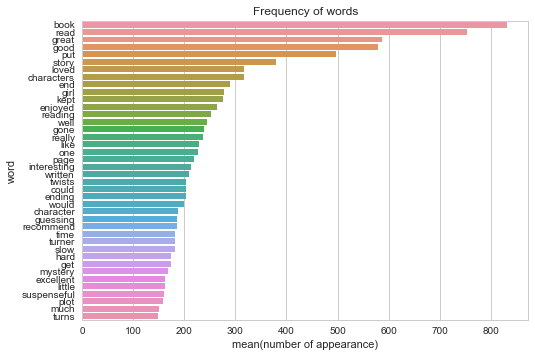

In [34]:
print("Wait, bags of words are being created!!\n")
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the function that will compute the frequencies for all words
vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 

# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(toy_data['processed'])

# Convert the result to an array
train_data_features = train_data_features.toarray()

# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)

import seaborn as sns
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)
plt.title('Frequency of words')
plt.show()

# Classification

In [35]:
labels = toy_data['sentiment']
# We split the data into train and test data. Here we keep 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  0.562309741973877
Confusion matrix, without normalization
[[385 426 453]
 [375 416 429]
 [382 381 500]]


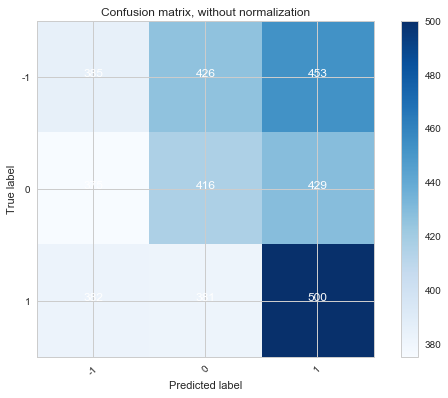

             precision    recall  f1-score   support

   class -1       0.34      0.30      0.32      1264
    class 0       0.34      0.34      0.34      1220
    class 1       0.36      0.40      0.38      1263

avg / total       0.35      0.35      0.35      3747

The accuracy is:  0.347211102215


In [36]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = 10)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  17.61738395690918
Confusion matrix, without normalization
[[450 445 369]
 [441 431 348]
 [423 434 406]]


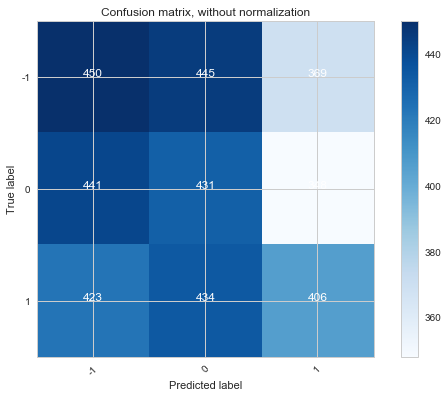

             precision    recall  f1-score   support

   class -1       0.34      0.36      0.35      1264
    class 0       0.33      0.35      0.34      1220
    class 1       0.36      0.32      0.34      1263

avg / total       0.34      0.34      0.34      3747

The accuracy is:  0.343474779824


In [37]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 30, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  2.329176664352417
Confusion matrix, without normalization
[[193 187 884]
 [166 193 861]
 [151 166 946]]


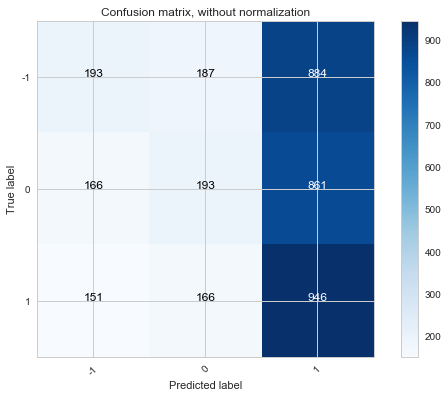

             precision    recall  f1-score   support

   class -1       0.38      0.15      0.22      1264
    class 0       0.35      0.16      0.22      1220
    class 1       0.35      0.75      0.48      1263

avg / total       0.36      0.36      0.31      3747

The accuracy is:  0.35548438751


In [38]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Remarks

We remark that the features resulted from both count vectorizer and tf-idf vectorizer give approximately the same results. If the classification algorithms provide better results than a random guess ($33.33\%$ accuracy), the performance here is not very good, with a best accuracy of $30\%$ for the logistic regression.

# Strategy 2: Word Embedding

[Mikolov](https://scholar.google.com/citations?user=oBu8kMMAAAAJ) has contributed a lot in the field of [word embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) using deep learning. His first models skip-gram and CBOW have lead to lots of work to imrove the way we embed objects into vectors (including words, in our contexts).

We will use the implementation of $Word2Vec$ from the package [Gensim](https://radimrehurek.com/gensim/).

### Prepare the data for gensim $Word2Vec$ model

In [39]:
def process(x, remove_stopwords=False):
    '''
    Function to clear the html tags, then remove non-letters characters, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''
    # Clean html tags
    review = BeautifulSoup(x, "html.parser").get_text() 
    # Remove non letters     
    letters = re.sub("[^a-zA-Z]", " ", review) 
    # Lowercase and split to words
    words = letters.lower().split()                             
    # It appears that searching in a set in Python is much more efficient than searching in a list
    stops = set(stopwords.words("english"))                  
    # Optionally remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words 

import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Function that splits reviews into sentences
def review_to_sentences(review, tokenizer, remove_stopwords=False ):
    '''Function to split a review into parsed sentences. Returns a 
    list of sentences, where each sentence is a list of words
    '''
    
    # Split into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(process(raw_sentence, remove_stopwords))
            
    # Return the list of sentences (each sentence is a list of words, so this returns a list of lists
    return sentences

In [40]:
# Apply the function to the whole toy dataset
start = time.time()

sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for review in toy_data["review"]:
    sentences += review_to_sentences(review, tokenizer)
      
print(time.time() - start)

Parsing sentences from training set


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.. .'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


22.03115749359131


### Build the $Word2Vec$ model and save it

We will embed words into $300$ dimensions vectors, with a context of size $10$. We only keep words which appear at least $40$ times.

In [41]:
start = time.time()
# The logging package enables to output messages during preparation

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)


# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. This is the most costly in computation time!
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

model.init_sims(replace=True)

# Save the model
model_name = "300features_40minwords_10context_toy_dataset"
model.save(model_name)

print(time.time() - start)

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\gensim\utils.py:843: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2017-01-31 20:26:11,904 : INFO : 'pattern' package not found; tag filters are not available for English
2017-01-31 20:26:11,920 : INFO : collecting all words and their counts
2017-01-31 20:26:11,920 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-01-31 20:26:11,951 : INFO : PROGRESS: at sentence #10000, processed 124848 words, keeping 6190 word types
2017-01-31 20:26:11,982 : INFO : PROGRESS: at sentence #20000, processed 235880 words, keeping 8200 word types
2017-01-31 20:26:12,014 : INFO : PROGRESS: at sentence #30000, processed 373242 words, keeping 10331 word types
2017-01-31 20:26:12,029 : INFO : collected 10630 word types from a corpus of 414162 raw words and 35243 sentences
2017-01-31 20:26:12,029 : INFO : Loading a fresh voca

Training model...


2017-01-31 20:26:12,092 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,092 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,123 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,123 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,139 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,154 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,170 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-01-31 20:26:12,170 : WARNING : direct access to vocab wil

1.9596436023712158


## Exploration of the model we created

In [42]:
from gensim.models import Word2Vec

model = Word2Vec.load("300features_40minwords_10context_toy_dataset")

2017-01-31 20:26:40,453 : INFO : loading Word2Vec object from 300features_40minwords_10context_toy_dataset
2017-01-31 20:26:40,468 : INFO : loading wv recursively from 300features_40minwords_10context_toy_dataset.wv.* with mmap=None
2017-01-31 20:26:40,468 : INFO : setting ignored attribute syn0norm to None
2017-01-31 20:26:40,468 : WARNING : direct access to syn0norm will not be supported in future gensim releases, please use model.wv.syn0norm
2017-01-31 20:26:40,484 : INFO : setting ignored attribute cum_table to None
2017-01-31 20:26:40,484 : INFO : loaded 300features_40minwords_10context_toy_dataset
2017-01-31 20:26:40,484 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word


In [43]:
# Size of the matrice created
model.syn0.shape

2017-01-31 20:26:42,077 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


(826, 300)

In [44]:
# Example of a word vector
model['good']

array([  1.34e-02,  -5.26e-02,   1.08e-01,   9.25e-03,  -3.45e-02,
        -7.30e-02,  -7.94e-02,  -2.89e-02,  -5.01e-03,  -2.72e-02,
         4.84e-02,   3.06e-02,   7.18e-03,   1.47e-02,  -4.60e-02,
        -5.64e-02,  -3.42e-02,  -2.72e-02,  -1.28e-01,   6.53e-02,
         6.77e-02,  -1.22e-01,  -2.24e-02,   2.88e-02,   1.46e-02,
        -2.04e-03,   3.14e-02,  -3.15e-02,   1.19e-03,  -1.10e-02,
         5.13e-02,  -2.08e-02,   1.55e-03,   2.71e-03,  -5.07e-02,
        -5.62e-02,   5.96e-02,   5.57e-02,  -4.48e-02,   5.68e-02,
        -1.55e-01,   1.89e-02,  -6.58e-02,   3.36e-02,  -5.14e-02,
        -3.45e-02,   1.02e-02,   4.84e-02,   8.89e-03,  -4.22e-02,
        -1.40e-01,   8.07e-02,  -1.35e-02,  -1.02e-02,   2.00e-02,
         4.81e-02,   3.75e-02,  -5.14e-02,  -6.91e-02,   4.85e-02,
         7.07e-02,   7.37e-02,  -5.63e-02,  -3.50e-02,   6.81e-02,
        -3.91e-02,   2.76e-02,   7.02e-02,   6.14e-02,   1.94e-02,
        -4.98e-02,  -1.14e-02,   1.12e-03,   1.07e-01,   2.50e

In [45]:
# Example of word similarity
model.most_similar('have')

2017-01-31 20:26:46,787 : INFO : precomputing L2-norms of word weight vectors


[('wish', 0.7336536049842834),
 ('ve', 0.7033239603042603),
 ('believe', 0.6202813386917114),
 ('maybe', 0.6190702319145203),
 ('give', 0.5763474702835083),
 ('been', 0.5753400921821594),
 ('already', 0.5637931823730469),
 ('given', 0.5521359443664551),
 ('since', 0.5467914342880249),
 ('ever', 0.5464085340499878)]

In [46]:
model.most_similar('good')

[('great', 0.8535372018814087),
 ('decent', 0.8240993022918701),
 ('fun', 0.7751692533493042),
 ('entertaining', 0.7333318591117859),
 ('enjoyable', 0.7160481214523315),
 ('nice', 0.7060836553573608),
 ('satisfying', 0.7029126882553101),
 ('fantastic', 0.6745709776878357),
 ('awesome', 0.6699577569961548),
 ('thrilling', 0.6507682800292969)]

In [47]:
# Distinguished the most distant word between several words
print(model.doesnt_match("man woman child dog".split()))

print(model.doesnt_match("amazing wonderful great window".split()))

man
window


Here, we see that the word embeddings seem not to be very good. This is due to the fact that we have trained the $Word2Vec$ model on a too small dataset. We will come back to this in a second part with the whole dataset.

#### Once we have word vectors, how can we create features for reviews?
#### One possibility is to average all the word vectors from the review

In [48]:
def makeFeatureVec(words, model, num_features):
    ''' 
    Function to average all the word vectors in a given review
    '''
    # Initialize an empty array
    featureVec = np.zeros((num_features,),dtype="float32")
    
    nwords = 0.
    
    # Index2word is a list that contains the names of the words in the model's vocabulary. Convert it to a set, for speed (juyst as we did before)
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word in the review and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    ''' 
    Given a set of reviews (each one a list of words), compute 
    the average feature vector for each one and return an array
    '''
    # Initialize a counter
    counter = 0
    
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    
    # Loop through the reviews
    for review in reviews:
        
        # Print a status message every 1000th review
        if counter%1000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))
        
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [49]:
# Compute the average feature vectors, using the functions we defined above.
start = time.time()
print("Creating average feature vecs for train reviews")

clean_train_reviews = []
for review in list(toy_data["review"]):
    clean_train_reviews.append(process(review, remove_stopwords=True))
print('reviews cleaned')
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

print(time.time() - start)

Creating average feature vecs for train reviews
reviews cleaned
Review 0 of 12489
Review 1000 of 12489
Review 2000 of 12489


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


Review 3000 of 12489
Review 4000 of 12489
Review 5000 of 12489
Review 6000 of 12489
Review 7000 of 12489
Review 8000 of 12489
Review 9000 of 12489
Review 10000 of 12489
Review 11000 of 12489
Review 12000 of 12489
14.493547916412354


# Classification

In [50]:
labels = toy_data['sentiment']
# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(trainDataVecs, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

In [51]:
start = time.time()

# Initialize the model
clf = LogisticRegression(C = 0.001)

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print(time.time() - start)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

It appears that some nans have been produced... How many?

In [52]:
np.isnan(data_train).sum() / (data_train.shape[0] * data_train.shape[1])

0.0070921985815602835

In [53]:
X = pd.concat((pd.DataFrame(trainDataVecs), toy_data['sentiment']), axis=1).dropna()
train_data = X.ix[:, :-1]
train_label = X.ix[:, -1]

# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data, 
                                                                    train_label, test_size=0.3, 
                                                                    random_state=42)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  1.3627712726593018
Confusion matrix, without normalization
[[350 478 415]
 [341 480 381]
 [314 446 512]]


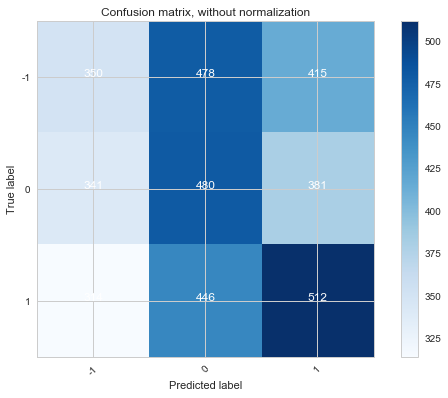

             precision    recall  f1-score   support

   class -1       0.35      0.28      0.31      1243
    class 0       0.34      0.40      0.37      1202
    class 1       0.39      0.40      0.40      1272

avg / total       0.36      0.36      0.36      3717

The accuracy is:  0.361043852569


In [60]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = .9)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  5.015347480773926
Confusion matrix, without normalization
[[423 450 370]
 [408 446 348]
 [394 410 468]]


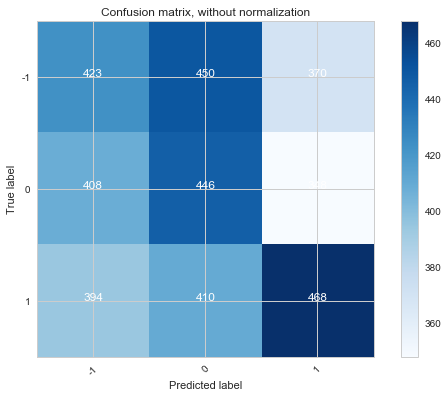

             precision    recall  f1-score   support

   class -1       0.35      0.34      0.34      1243
    class 0       0.34      0.37      0.36      1202
    class 1       0.39      0.37      0.38      1272

avg / total       0.36      0.36      0.36      3717

The accuracy is:  0.359698681733


In [61]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 30, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  0.1315310001373291
Confusion matrix, without normalization
[[132 725 386]
 [129 762 311]
 [127 679 466]]


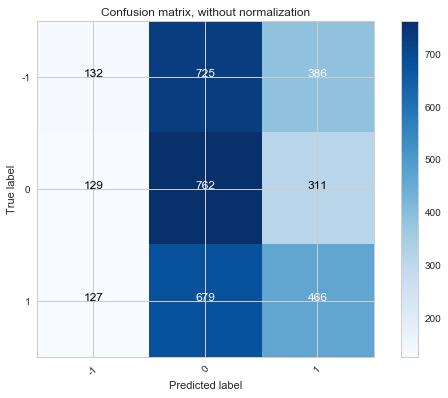

             precision    recall  f1-score   support

   class -1       0.34      0.11      0.16      1243
    class 0       0.35      0.63      0.45      1202
    class 1       0.40      0.37      0.38      1272

avg / total       0.36      0.37      0.33      3717

The accuracy is:  0.365886467581


In [62]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

## Clustering

Since we have embedded our vectors in a $300$ dimensions space, we have a metric, and we can make clustering of words, hence producing clusters of words. We will use these clusters to create features for the reviews.

In [63]:
from sklearn.cluster import KMeans

start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size (this is an arbitrary choice)
word_vectors = model.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

2017-01-31 20:35:00,208 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


Time taken for K Means clustering:  1.6585869789123535 seconds.


In [64]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip(model.index2word, idx))

2017-01-31 20:35:35,858 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word


In [65]:
# Display the first 10 clusters
for cluster in range(0,10):
    
    # Print the cluster number  
    print("\nCluster %d" % cluster)
    
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['reveal', 'who', 'guy', 'talking', 'murderer', 'killer', 'idea']

Cluster 1
['dialogue', 'completely', 'totally', 'ultimately', 'unbelievable', 'flat', 'mostly', 'slightly', 'climax', 'complicated', 'action', 'itself', 'frustrating']

Cluster 2
['hope', 'call']

Cluster 3
['along', 'moves', 'unfolds', 'builds', 'and']

Cluster 4
['beginning', 'start', 'hooked']

Cluster 5
['constantly', 'pieces', 'names', 'clear', 'truth', 'sense', 'name', 'speaking', 'whom']

Cluster 6
['police', 'married', 'marriage', 'him', 'memory', 'picture', 'fantasy', 'tom', 'alcohol', 'reality', 'feels', 'depressed', 'blackouts', 'scott', 'problem', 'baby', 'lost', 'blackout']

Cluster 7
['rating', 'club', 'bought', 'star']

Cluster 8
['then', 'up', 'night']

Cluster 9
['kindle', 'wasted', 'finishing', 'waste', 'library', 'hours', 'spent', 'money', 'stayed', 'decided', 'expectations']


Now, let's create our bags of centroïds

In [66]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # Return the "bag of centroids"
    return bag_of_centroids

# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((toy_data["sentiment"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [67]:
np.isnan(train_centroids).sum() # There are no missing values

0

In [68]:
# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_centroids, 
                                                                    toy_data['sentiment'], test_size=0.3)


# Classification

#### Logistic Regression

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  0.1177833080291748
Confusion matrix, without normalization
[[320 324 593]
 [337 339 568]
 [320 305 641]]


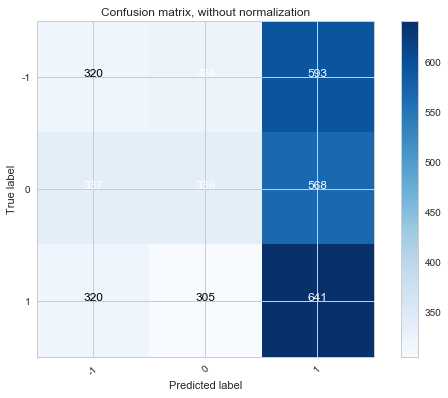

             precision    recall  f1-score   support

   class -1       0.33      0.26      0.29      1237
    class 0       0.35      0.27      0.31      1244
    class 1       0.36      0.51      0.42      1266

avg / total       0.34      0.35      0.34      3747

The accuracy is:  0.346944222044


In [72]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = 1)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  0.3072066307067871
Confusion matrix, without normalization
[[469 400 368]
 [449 443 352]
 [437 417 412]]


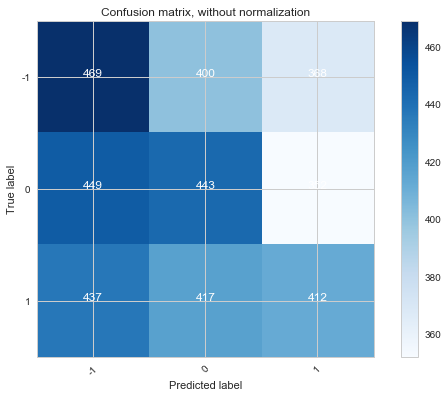

             precision    recall  f1-score   support

   class -1       0.35      0.38      0.36      1237
    class 0       0.35      0.36      0.35      1244
    class 1       0.36      0.33      0.34      1266

avg / total       0.35      0.35      0.35      3747

The accuracy is:  0.353349346144


In [77]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 10, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  0.06250762939453125
Confusion matrix, without normalization
[[209 162 866]
 [198 164 882]
 [143 153 970]]


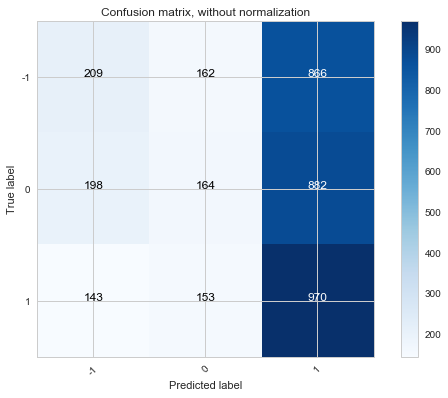

             precision    recall  f1-score   support

   class -1       0.38      0.17      0.23      1237
    class 0       0.34      0.13      0.19      1244
    class 1       0.36      0.77      0.49      1266

avg / total       0.36      0.36      0.30      3747

The accuracy is:  0.358420069389


In [78]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Conclusion of word embeddings: it seems that the methods dos not enable to have good results in the cllassification part.

# Whole dataset

From now on, we will carry out the same methodology as before, but this time with the whole dataset!

# Strategy 1: Bag of Words Model

In [82]:
data['sentiment'] = data['rating'].apply(lambda x: sentiment(x))

print(data.sentiment.value_counts())
print('Minimum representation for classes:', data.sentiment.value_counts().min())

 1    157061
-1     37799
 0     24382
Name: sentiment, dtype: int64
Minimum representation for classes: 24382


24382


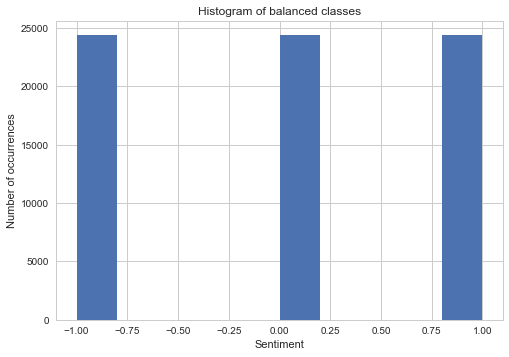

In [91]:
# Index of positive, negative and neutral data
index_positive = list(data[data.sentiment == 1].index)
index_negative = list(data[data.sentiment == -1].index)
index_neutral = list(data[data.sentiment == 0].index)

# Sample over the negative and positive data
min_class = data.sentiment.value_counts().min()
print(min_class)
index_positive_sample = list(data.ix[index_positive].sample(min_class).index)
index_negative_sample = list(data.ix[index_negative].sample(min_class).index)
index_final = index_negative_sample + index_positive_sample + index_neutral

# We define our toy dataset with balanced classes
total_data = data.ix[index_final]
# Reset the index
total_data = total_data.reset_index().ix[:, 1:]

# Plot the histogram of classes
plt.hist(total_data.sentiment)
plt.title('Histogram of balanced classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of occurrences')
plt.show()

In [93]:
# Size of the resulting toy dataset
print('Our toy dataset has now {} rows'.format(total_data.shape[0]))

Our toy dataset has now 73146 rows


In [95]:
def process(x):
    '''
    Function to clear the html tags, then remove non-letters characters, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''

    # Clean html tags
    review = BeautifulSoup(x, "html.parser").get_text() 
    
    # Remove non letters     
    letters = re.sub("[^a-zA-Z]", " ", review) 
    
    # Lowercase and split to words
    words = letters.lower().split()                              
    
    # Join to produce the cleaned texts 

    return(" ".join(words))

total_data['processed'] = total_data['review'].apply(lambda x: process(x))
def remove_stop_words(review):
    review = review.split()
    stops = set(stopwords.words("english"))                  
    text = [w for w in review if not w in stops]   
    return(" ".join(text))  
total_data['processed'] = total_data['processed'].apply(lambda x: remove_stop_words(x))

#### Count Vectorizer

Wait, bags of words are being created!!

The model has been learned!


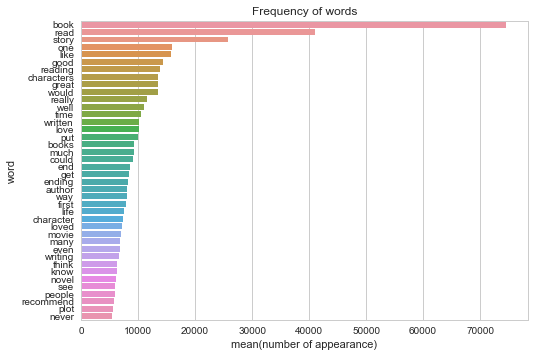

In [96]:
print("Wait, bags of words are being created!!\n")
# Define the function that will compute the frequencies for all words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 
# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(total_data['processed'])
# Convert the result to an array
train_data_features = train_data_features.toarray()

print('The model has been learned!')
size = train_data_features.shape
sparsity = np.count_nonzero(train_data_features) / train_data_features.size
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)

ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)
plt.title('Frequency of words')
plt.show()

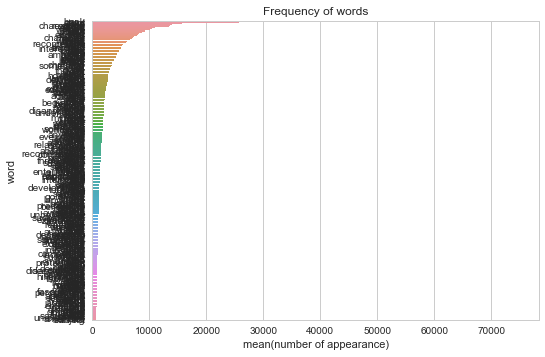

In [97]:
ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(500)
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)
plt.title('Frequency of words')
plt.show()

# Classification

In [98]:
labels = total_data['sentiment']
# We split the data into train and test data. Here we keep 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  4.996835947036743
The accuracy is:  0.447776157492
Confusion matrix, without normalization
[[3247 1694 2345]
 [1724 2595 2964]
 [1429 1962 3984]]


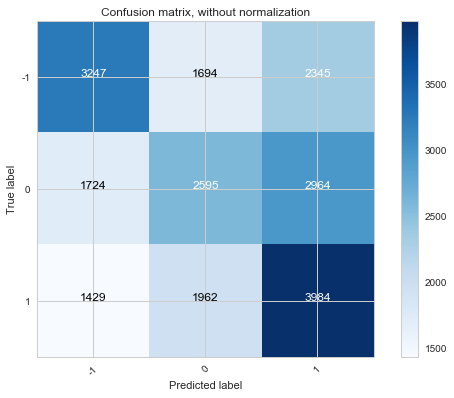

             precision    recall  f1-score   support

   class -1       0.51      0.45      0.47      7286
    class 0       0.42      0.36      0.38      7283
    class 1       0.43      0.54      0.48      7375

avg / total       0.45      0.45      0.45     21944

The accuracy is:  0.447776157492


In [99]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C=.01)
# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)
print("Computation time: ", time.time() - start)

print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  83.94241571426392
Confusion matrix, without normalization
[[3698 1811 1777]
 [2386 2600 2297]
 [2156 2222 2997]]


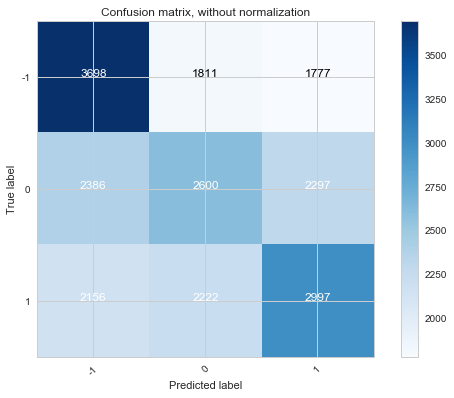

             precision    recall  f1-score   support

   class -1       0.45      0.51      0.48      7286
    class 0       0.39      0.36      0.37      7283
    class 1       0.42      0.41      0.41      7375

avg / total       0.42      0.42      0.42     21944

The accuracy is:  0.423578199052


In [100]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 20, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  13.391166687011719
Confusion matrix, without normalization
[[2181  700 4405]
 [ 970 1093 5220]
 [ 749  852 5774]]


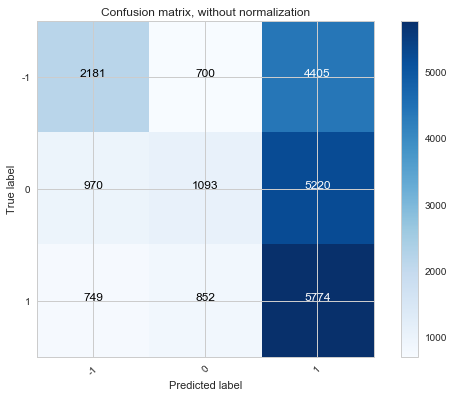

             precision    recall  f1-score   support

   class -1       0.56      0.30      0.39      7286
    class 0       0.41      0.15      0.22      7283
    class 1       0.37      0.78      0.51      7375

avg / total       0.45      0.41      0.37     21944

The accuracy is:  0.412322274882


In [102]:

start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### TF-IDF Vectorizer

In [ ]:
# Define the function that will compute the frequencies for all words
vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 

# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(total_data['processed'])

# Convert the result to an array
train_data_features = train_data_features.toarray()

# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)

import seaborn as sns
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)
plt.title('Frequency of words')
plt.show()

# Classification

In [103]:
labels = total_data['sentiment']
# We split the data into train and test data. Here we keep 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  39.95616793632507
Confusion matrix, without normalization
[[3034 1895 2357]
 [1851 2513 2919]
 [1692 2137 3546]]


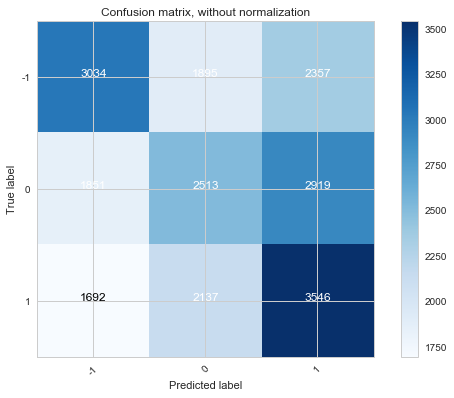

             precision    recall  f1-score   support

   class -1       0.46      0.42      0.44      7286
    class 0       0.38      0.35      0.36      7283
    class 1       0.40      0.48      0.44      7375

avg / total       0.42      0.41      0.41     21944

The accuracy is:  0.414372949326


In [104]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = 10)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  125.84468388557434
Confusion matrix, without normalization
[[3617 1855 1814]
 [2274 2763 2246]
 [2048 2351 2976]]


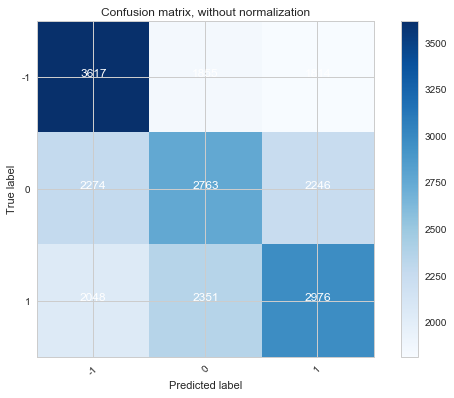

             precision    recall  f1-score   support

   class -1       0.46      0.50      0.48      7286
    class 0       0.40      0.38      0.39      7283
    class 1       0.42      0.40      0.41      7375

avg / total       0.43      0.43      0.43     21944

The accuracy is:  0.426358002187


In [105]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 30, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  13.640745878219604
Confusion matrix, without normalization
[[2181  700 4405]
 [ 970 1093 5220]
 [ 749  852 5774]]


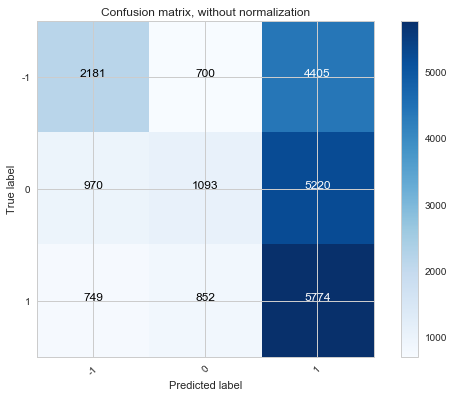

             precision    recall  f1-score   support

   class -1       0.56      0.30      0.39      7286
    class 0       0.41      0.15      0.22      7283
    class 1       0.37      0.78      0.51      7375

avg / total       0.45      0.41      0.37     21944

The accuracy is:  0.412322274882


In [107]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Remark: 
We observe that our score is way better with a larger corpus.

# Strategy 2: Word Embedding

In [109]:
def process(x, remove_stopwords=False):
    '''
    Function to clear the html tags, then remove non-letters characters, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''
    # Clean html tags
    review = BeautifulSoup(x, "html.parser").get_text() 
    # Remove non letters     
    letters = re.sub("[^a-zA-Z]", " ", review) 
    # Lowercase and split to words
    words = letters.lower().split()                             
    # It appears that searching in a set in Python is much more efficient than searching in a list
    stops = set(stopwords.words("english"))                  
    # Optionally remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words 

# Apply the function to the whole toy dataset
start = time.time()

sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for review in total_data["review"]:
    sentences += review_to_sentences(review, tokenizer)
      
print(time.time() - start)

Parsing sentences from training set


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'....'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.. .'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


189.42700958251953


In [ ]:
# Build the model

start = time.time()
# The logging package enables to output messages during preparation

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)


# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. This is the most costly in computation time!
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

model.init_sims(replace=True)

# Save the model
model_name = "300features_40minwords_10context_total_dataset"
model.save(model_name)

print(time.time() - start)

2017-01-31 21:11:44,413 : INFO : collecting all words and their counts
2017-01-31 21:11:44,413 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-01-31 21:11:44,460 : INFO : PROGRESS: at sentence #10000, processed 151377 words, keeping 8811 word types
2017-01-31 21:11:44,491 : INFO : PROGRESS: at sentence #20000, processed 300828 words, keeping 12424 word types
2017-01-31 21:11:44,522 : INFO : PROGRESS: at sentence #30000, processed 452126 words, keeping 15117 word types
2017-01-31 21:11:44,553 : INFO : PROGRESS: at sentence #40000, processed 604791 words, keeping 17220 word types
2017-01-31 21:11:44,585 : INFO : PROGRESS: at sentence #50000, processed 751528 words, keeping 19046 word types


Training model...


2017-01-31 21:11:44,631 : INFO : PROGRESS: at sentence #60000, processed 903370 words, keeping 20737 word types
2017-01-31 21:11:44,663 : INFO : PROGRESS: at sentence #70000, processed 1049834 words, keeping 22129 word types
2017-01-31 21:11:44,694 : INFO : PROGRESS: at sentence #80000, processed 1198487 words, keeping 23528 word types
2017-01-31 21:11:44,725 : INFO : PROGRESS: at sentence #90000, processed 1349227 words, keeping 24751 word types
2017-01-31 21:11:44,756 : INFO : PROGRESS: at sentence #100000, processed 1494646 words, keeping 25816 word types
2017-01-31 21:11:44,803 : INFO : PROGRESS: at sentence #110000, processed 1643218 words, keeping 26861 word types
2017-01-31 21:11:44,835 : INFO : PROGRESS: at sentence #120000, processed 1780992 words, keeping 27831 word types
2017-01-31 21:11:44,866 : INFO : PROGRESS: at sentence #130000, processed 1914548 words, keeping 28669 word types
2017-01-31 21:11:44,897 : INFO : PROGRESS: at sentence #140000, processed 2044486 words, keep

In [ ]:
model_total = Word2Vec.load("300features_40minwords_10context_total_dataset")
# Size of the matrice created
model_total.syn0.shape

In [ ]:
# Example of a word vector
model_total['good']

In [ ]:
# Example of word similarity
model_total.most_similar('have')

In [ ]:
model_total.most_similar('good')

In [ ]:
# Distinguished the most distant word between several words
print(model_total.doesnt_match("man woman child dog".split()))

print(model_total.doesnt_match("amazing wonderful great window".split()))

## Vector Averaging

In [ ]:
# Compute the average feature vectors, using the functions we defined above.
start = time.time()
print("Creating average feature vecs for train reviews")

clean_train_reviews = []
for review in list(total_data["review"]):
    clean_train_reviews.append(process(review, remove_stopwords=True))
print('reviews cleaned')
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model_total, num_features)

print(time.time() - start)

# Classification

In [ ]:
# Get rid of nans
X = pd.concat((pd.DataFrame(trainDataVecs), total_data['sentiment']), axis=1).dropna()
train_data = X.ix[:, :-1]
train_label = X.ix[:, -1]

labels = total_data['sentiment']
# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data, 
                                                                    train_label, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

In [ ]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = .9)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

In [ ]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 30, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

In [ ]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

## Clustering

In [ ]:
start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size (this is an arbitrary choice)
word_vectors = model_total.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

In [ ]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip(model.index2word, idx))

In [ ]:
# Display the first 10 clusters
for cluster in range(0,10):
    
    # Print the cluster number  
    print("\nCluster %d" % cluster)
    
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)

In [ ]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((toy_data["sentiment"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [ ]:
# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_centroids, 
                                                                    toy_data['sentiment'], test_size=0.3)

# Classification

#### Logistic Regression

In [ ]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = 1)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Random Forest

In [ ]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 10, class_weight="balanced")

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

#### Naive Bayes

In [ ]:
start = time.time()
# Initialize the model
print('Initialize the model')
clf = GaussianNB()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

# Use the plotting function
cnf_matrix = confusion_matrix(labels_test, labels_predicted)
np.set_printoptions(precision=2)
class_names = sorted(toy_data.sentiment.unique())
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

print(classification_report(labels_test, labels_predicted, target_names=target_names))
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))